In [2]:
# 导入数据科学常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 导入机器学习模型与评估工具
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 设置绘图风格，让图表更好看 (Presentation 加分项)
sns.set(style="whitegrid")
%matplotlib inline

print("库导入成功！环境配置完成。")

库导入成功！环境配置完成。


In [7]:
# --- 配置参数 ---
# 请将文件名替换为你下载的真实 CICIDS2017 CSV 文件名
file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

# 采样比例：0.1 表示使用 10% 的数据快速跑通，最终报告建议改为 1.0 (全量)
sample_frac = 0.1

# --- 加载数据 ---
try:
    print(f"正在读取文件: {file_path} ...")
    df = pd.read_csv(file_path)

    # 去除列名的空格 (CICIDS 数据的常见问题)
    df.columns = df.columns.str.strip()

    print(f"原始数据维度: {df.shape}")

    # 采样 (为了演示速度)
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42)
        print(f"采样后维度: {df.shape}")

    # --- 关键清洗步骤 (Implementation 重点) ---
    # 处理无穷大 (Infinity) 和 空值 (NaN)
    print("正在清洗脏数据 (Infinity & NaN)...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    before_drop = df.shape[0]
    df.dropna(inplace=True)
    print(f"清洗完成，丢弃了 {before_drop - df.shape[0]} 行坏数据。")

    # 展示前5行数据
    display(df.head())

except FileNotFoundError:
    print("❌ 错误：找不到文件。请检查文件名是否正确，或者是否上传到了 Jupyter 目录中。")

正在读取文件: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
原始数据维度: (225745, 79)
采样后维度: (22574, 79)
正在清洗脏数据 (Infinity & NaN)...
清洗完成，丢弃了 6 行坏数据。


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
127940,80,9392887,4,0,24,0,6,6,6.000000,0.000000,...,20,1.982000e+03,0.0000,1982,1982,9390905.0,0.0000,9390905,9390905,DDoS
195330,64007,5438011,1,5,6,30,6,6,6.000000,0.000000,...,20,2.715100e+04,0.0000,27151,27151,5410860.0,0.0000,5410860,5410860,BENIGN
202016,80,115615609,20,15,1728,3463,578,0,86.400000,211.017934,...,32,1.609163e+05,134508.6864,566475,120118,10100000.0,46752.4843,10100000,9988018,BENIGN
18959,80,9827,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,DDoS
120928,53315,87583370,7,9,11607,62,4380,0,1658.142857,1762.272815,...,20,4.219842e+06,0.0000,4219842,4219842,82600000.0,0.0000,82600000,82600000,BENIGN


样本分布情况：
Malicious    12917
Normal        9651
Name: Label_Binary, dtype: int64


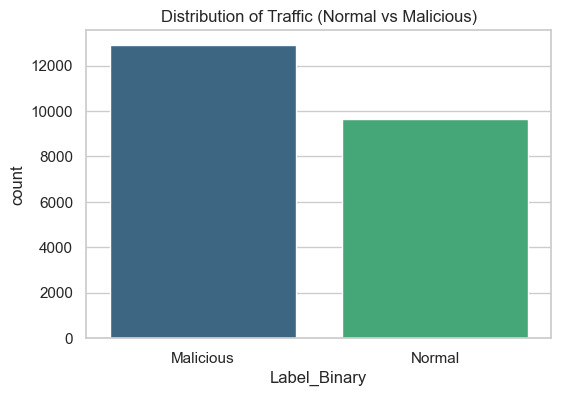

✅ 数据预处理完成，准备训练！


In [10]:
# 1. 标签处理：将多分类转换为二分类 (Normal vs Malicious)
# 如果标签是 'BENIGN' 则是正常，否则标记为 'Malicious'
df['Label_Binary'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Malicious')

# 查看正负样本分布
print("样本分布情况：")
print(df['Label_Binary'].value_counts())

# 画个图展示分布（可以放在 PPT 里展示数据不平衡）
plt.figure(figsize=(6,4))

# --- 【这里是修改的地方】 ---
# 旧写法: sns.countplot(x='Label_Binary', data=df, palette='viridis')
# 新写法 (修复警告): 加上 hue='Label_Binary' 和 legend=False
sns.countplot(x='Label_Binary', hue='Label_Binary', data=df, palette='viridis', legend=False)
# -------------------------

plt.title("Distribution of Traffic (Normal vs Malicious)")
plt.show()

# 2. 准备训练数据
# 删除原始标签和辅助列
# 【注意】为了防止之后的步骤报错，我们只保留数字列，并排除我们刚才生成的 Label_Binary
df_numeric = df.select_dtypes(include=[np.number])
X = df_numeric.copy() # 确保只包含数字

# 确保目标变量 y 对应
y = df['Label_Binary']

# 标签数字化 (Normal->0, Malicious->1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. 划分训练集和测试集 (80% 训练, 20% 测试)
# 加上 stratify=y_encoded 确保训练集和测试集里攻击流量的比例一致
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4. 特征缩放 (Standardization) - 网络流量数值差异大，必须缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ 数据预处理完成，准备训练！")

In [12]:
print("🚀 开始训练随机森林模型...")
# n_estimators=100 表示使用100棵决策树
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 训练模型
rf_model.fit(X_train_scaled, y_train)

print("✅ 模型训练结束！")

🚀 开始训练随机森林模型...
✅ 模型训练结束！


=== 分类报告 (Classification Report) ===
              precision    recall  f1-score   support

   Malicious       1.00      1.00      1.00      2584
      Normal       1.00      1.00      1.00      1930

    accuracy                           1.00      4514
   macro avg       1.00      1.00      1.00      4514
weighted avg       1.00      1.00      1.00      4514



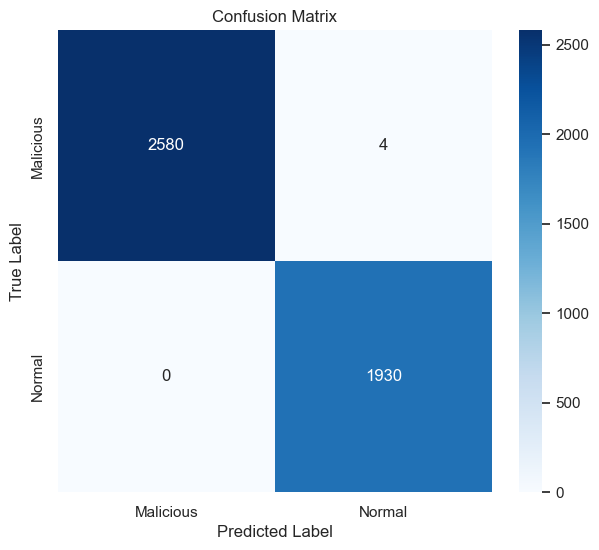

In [13]:
# 进行预测
y_pred = rf_model.predict(X_test_scaled)

# 1. 输出详细分类报告 (Precision, Recall, F1-Score)
print("=== 分类报告 (Classification Report) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 2. 绘制混淆矩阵 (Confusion Matrix)
# 这个图必须截图放到 PPT 里，证明你们不仅看准确率，还关注漏报/误报
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

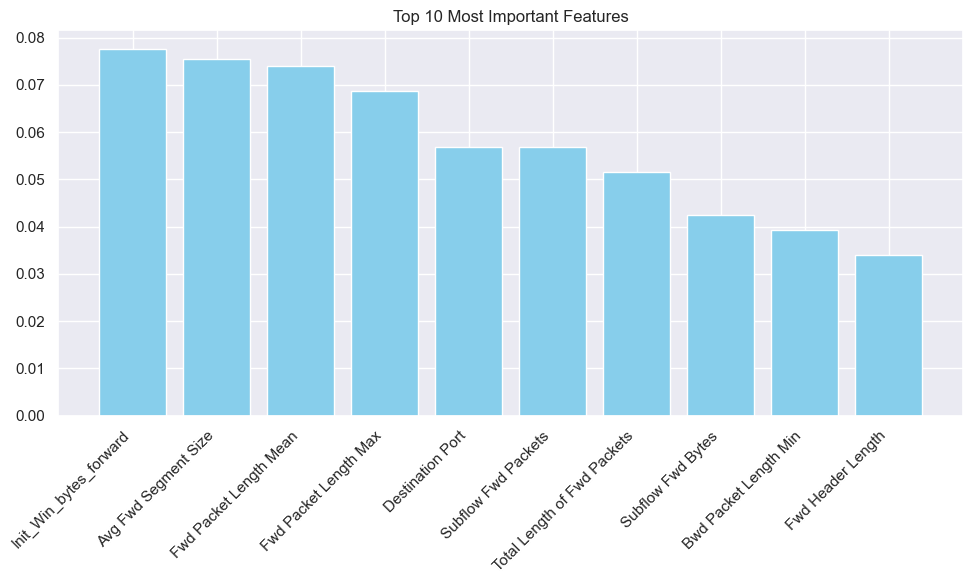

💡 分析：这些特征是模型认为最能区分'攻击'和'正常'流量的关键指标。


In [15]:
# 提取特征重要性
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:10] # 取前10个最重要的特征

# 绘图
plt.figure(figsize=(10, 6))
plt.title('Top 10 Most Important Features')
plt.bar(range(10), importances[indices], align='center', color='skyblue')
plt.xticks(range(10), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("💡 分析：这些特征是模型认为最能区分'攻击'和'正常'流量的关键指标。")